In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import plotly.graph_objs as go
from plotly import tools
import load
import descriptions
import gensim
import random
po.init_notebook_mode(connected=True)

## Patient pathway

In [3]:
#this was made from the cancerdata_EDA.ipynb
full_patient_pathways = pd.read_pickle('full_patient_pathways.pkl')

print("shape of patient_pathways ",full_patient_pathways.shape)
display(full_patient_pathways.head())

shape of patient_pathways  (777581, 111)


TUMOURID  PATIENTID DIAGNOSISDATEBEST SITE_ICD10_O2 SITE_ICD10_O2_3CHAR  \
15  10001198   10001198        2015-01-16          C443                 C44   
18  10335837   10001198        2015-01-16          C444                 D46   
16  10001198   10001198        2015-01-16          C443                 C44   
17  10001198   10001198        2015-01-16          C443                 C44   
19  10335837   10001198        2015-01-16          C444                 D46   

   MORPH_ICD10_O2 BEHAVIOUR_ICD10_O2 T_BEST N_BEST M_BEST  ...  \
15           8090                  3    NaN    NaN    NaN  ...   
18           8090                  1    NaN    NaN    NaN  ...   
16           8090                  3    NaN    NaN    NaN  ...   
17           8090                  3    NaN    NaN    NaN  ...   
19           8090                  1    NaN    NaN    NaN  ...   

   ORG_CODE_OF_DRUG_PROVIDER ACTUAL_DOSE_PER_ADMINISTRATION  \
15                       EOI                           55.0   
18                       EOI                           55.0   
16                       EGT                          600.0   
17                       EQM                           70.0   
19                       EGT                          600.0   

   OPCS_DELIVERY_CODE  ADMINISTRATION_ROUTE ADMINISTRATION_DATE    DRUG_GROUP  \
15                721                   1.0          2015-09-02       STEROID   
18                721                   1.0          2015-09-02       STEROID   
16                NaN                   1.0          2015-09-03  BENDAMUSTINE   
17                NaN                   1.0          2015-09-03     CISPLATIN   
19                NaN                   1.0          2015-09-03  BENDAMUSTINE   

    MERGED_PATIENT_ID MERGED_TUMOUR_ID_y MERGED_REGIMEN_ID_y  \
15           10001198           10002225            10003952   
18           10001198           10002225            10003952   
16           10001198           10002225            10003952   
17           10001198           10002225            10003952   
19           10001198           10002225            10003952   

   DRUG_GROUP_CORRECT  
15            STEROID  
18            STEROID  
16       BENDAMUSTINE  
17          CISPLATIN  
19       BENDAMUSTINE  

[5 rows x 111 columns]

# Assigning events

In [4]:
#only use 3 character icd10 codes for simplicity
full_patient_pathways['PRIMARY_DIAGNOSIS'] = full_patient_pathways['PRIMARY_DIAGNOSIS'].apply(lambda x: x[0:3])

The following cell treats a diagnosis,regimen taken and drug taken as an individual event. These can be obtained from full_patient_pathways by getting each column of those events and a column that has the dates of those events. We can stack all events which will get a sequence of events(as rows) per patient.

In [5]:
dates = ['DIAGNOSISDATEBEST','START_DATE_OF_REGIMEN','ADMINISTRATION_DATE']
event_types = ['PRIMARY_DIAGNOSIS','BENCHMARK_GROUP','DRUG_GROUP_CORRECT']

sequences_df = pd.DataFrame()

for date, event_type in zip(dates,event_types):
    
    #get the events and event dates,
    #we must drop duplicates as some are replicated due to the merging
    #in cancerdata_EDA
    df = full_patient_pathways[['PATIENTID', date, event_type]].drop_duplicates()
    df = df.rename(index=str, columns={date:'date', event_type:'event'})
    df['event_type'] = event_type
    
    #some drug group values are the same as there regimen values
    df['event'] = df['event_type'] + " " + df['event']
    
    #stack the events and event dates
    sequences_df = pd.concat([sequences_df,df])
    
sequences_df = sequences_df.sort_values(by = ['PATIENTID','date'])
    
sequences_df

PATIENTID                 date  \
15        10001198  2015-01-16 00:00:00   
15        10001198           2015-02-27   
15        10001198           2015-09-02   
16        10001198           2015-09-03   
17        10001198           2015-09-03   
21        10001976  2014-02-25 00:00:00   
24        10001976  2014-10-17 00:00:00   
21        10001976           2014-11-16   
21        10001976           2015-01-18   
22        10001976           2015-01-18   
23        10001976           2015-01-18   
27        10002361  2013-08-19 00:00:00   
27        10002361           2014-10-20   
27        10002361           2014-10-20   
28        10002361           2014-10-20   
29        10002568  2013-12-18 00:00:00   
29        10002568           2016-07-09   
29        10002568           2016-08-06   
30        10002568           2016-08-06   
31        10002568           2016-08-07   
32        10002568           2016-08-07   
33        10002568           2016-09-03   
34        10002929           2014-10-28   
34        10002929           2014-10-28   
35        10002929           2014-11-04   
34        10002929  2015-04-01 00:00:00   
38        10002929           2015-04-30   
38        10002929           2015-04-30   
39        10002929           2015-04-30   
40        10002929           2015-04-30   
...            ...                  ...   
1711432  220043022           2016-03-29   
1711433  220043022           2016-04-05   
1711444  220043080  2015-06-30 00:00:00   
1711444  220043080           2015-10-07   
1711444  220043080           2015-10-07   
1711445  220043080           2015-10-08   
1711446  220043080           2015-10-08   
1711447  220044037  2015-02-02 00:00:00   
1711447  220044037           2015-02-18   
1711447  220044037           2015-02-18   
1711448  220044037           2015-03-11   
1711449  220044037           2015-03-11   
1711450  220044037           2015-04-15   
1711451  220044037           2015-05-06   
1711452  220044037           2015-06-10   
1711453  220044037           2015-06-17   
1711454  220044037           2015-07-08   
1711456  220044540  2015-05-11 00:00:00   
1711456  220044540           2015-07-15   
1711456  220044540           2015-07-15   
1711457  220044540           2015-09-02   
1711457  220044540           2015-09-23   
1711458  220044540           2015-10-25   
1711459  220044540           2015-10-25   
1711461  220044540           2015-10-26   
1711462  220044540           2015-11-02   
1711463  220044540           2015-11-03   
1711464  220044540           2015-11-09   
1711465  220044540           2015-11-09   
1711467  220044540           2015-11-13   

                                                 event          event_type  
15                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS  
15                        BENCHMARK_GROUP FLUOROURACIL     BENCHMARK_GROUP  
15                          DRUG_GROUP_CORRECT STEROID  DRUG_GROUP_CORRECT  
16                     DRUG_GROUP_CORRECT BENDAMUSTINE  DRUG_GROUP_CORRECT  
17                        DRUG_GROUP_CORRECT CISPLATIN  DRUG_GROUP_CORRECT  
21                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS  
24                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS  
21             BENCHMARK_GROUP CISPLATIN + GEMCITABINE     BENCHMARK_GROUP  
21                            DRUG_GROUP_CORRECT TRIAL  DRUG_GROUP_CORRECT  
22                          DRUG_GROUP_CORRECT STEROID  DRUG_GROUP_CORRECT  
23                  DRUG_GROUP_CORRECT ZOLEDRONIC ACID  DRUG_GROUP_CORRECT  
27                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS  
27                        BENCHMARK_GROUP FLUOROURACIL     BENCHMARK_GROUP  
27                     DRUG_GROUP_CORRECT FLUOROURACIL  DRUG_GROUP_CORRECT  
28                        DRUG_GROUP_CORRECT NOT CHEMO  DRUG_GROUP_CORRECT  
29                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS  
29                           BENC

In [6]:
#add diagnosis of patient as a column for color coding later
cancers_df = full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
sequences_df = pd.merge(sequences_df,cancers_df,how='left',on='PATIENTID')

Assign each unique event a label

In [8]:
unique_events_df = sequences_df[['event']].drop_duplicates().reset_index(drop=True)
unique_events_df['event_label'] = unique_events_df.index.astype(str)
unique_events_df.head()

event event_label
0            PRIMARY_DIAGNOSIS C44           0
1     BENCHMARK_GROUP FLUOROURACIL           1
2       DRUG_GROUP_CORRECT STEROID           2
3  DRUG_GROUP_CORRECT BENDAMUSTINE           3
4     DRUG_GROUP_CORRECT CISPLATIN           4

Add the event_label into the sequences_df

In [9]:
sequences_df = pd.merge(sequences_df, unique_events_df, how='left',on='event')
sequences_df

PATIENTID                 date  \
0        10001198  2015-01-16 00:00:00   
1        10001198           2015-02-27   
2        10001198           2015-09-02   
3        10001198           2015-09-03   
4        10001198           2015-09-03   
5        10001976  2014-02-25 00:00:00   
6        10001976  2014-10-17 00:00:00   
7        10001976           2014-11-16   
8        10001976           2015-01-18   
9        10001976           2015-01-18   
10       10001976           2015-01-18   
11       10002361  2013-08-19 00:00:00   
12       10002361           2014-10-20   
13       10002361           2014-10-20   
14       10002361           2014-10-20   
15       10002568  2013-12-18 00:00:00   
16       10002568           2016-07-09   
17       10002568           2016-08-06   
18       10002568           2016-08-06   
19       10002568           2016-08-07   
20       10002568           2016-08-07   
21       10002568           2016-09-03   
22       10002929           2014-10-28   
23       10002929           2014-10-28   
24       10002929           2014-11-04   
25       10002929  2015-04-01 00:00:00   
26       10002929           2015-04-30   
27       10002929           2015-04-30   
28       10002929           2015-04-30   
29       10002929           2015-04-30   
...           ...                  ...   
797092  220043022           2016-03-29   
797093  220043022           2016-04-05   
797094  220043080  2015-06-30 00:00:00   
797095  220043080           2015-10-07   
797096  220043080           2015-10-07   
797097  220043080           2015-10-08   
797098  220043080           2015-10-08   
797099  220044037  2015-02-02 00:00:00   
797100  220044037           2015-02-18   
797101  220044037           2015-02-18   
797102  220044037           2015-03-11   
797103  220044037           2015-03-11   
797104  220044037           2015-04-15   
797105  220044037           2015-05-06   
797106  220044037           2015-06-10   
797107  220044037           2015-06-17   
797108  220044037           2015-07-08   
797109  220044540  2015-05-11 00:00:00   
797110  220044540           2015-07-15   
797111  220044540           2015-07-15   
797112  220044540           2015-09-02   
797113  220044540           2015-09-23   
797114  220044540           2015-10-25   
797115  220044540           2015-10-25   
797116  220044540           2015-10-26   
797117  220044540           2015-11-02   
797118  220044540           2015-11-03   
797119  220044540           2015-11-09   
797120  220044540           2015-11-09   
797121  220044540           2015-11-13   

                                                event          event_type  \
0                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS   
1                        BENCHMARK_GROUP FLUOROURACIL     BENCHMARK_GROUP   
2                          DRUG_GROUP_CORRECT STEROID  DRUG_GROUP_CORRECT   
3                     DRUG_GROUP_CORRECT BENDAMUSTINE  DRUG_GROUP_CORRECT   
4                        DRUG_GROUP_CORRECT CISPLATIN  DRUG_GROUP_CORRECT   
5                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS   
6                               PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS   
7             BENCHMARK_GROUP CISPLATIN + GEMCITABINE     BENCHMARK_GROUP   
8                            DRUG_GROUP_CORRECT TRIAL  DRUG_GROUP_CORRECT   
9                          DRUG_GROUP_CORRECT STEROID  DRUG_GROUP_CORRECT   
10                 DRUG_GROUP_CORRECT ZOLEDRONIC ACID  DRUG_GROUP_CORRECT   
11                              PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS   
12                       BENCHMARK_GROUP FLUOROURACIL     BENCHMARK_GROUP   
13                    DRUG_GROUP_CORRECT FLUOROURACIL  DRUG_GROUP_CORRECT   
14                       DRUG_GROUP_CORRECT NOT CHEMO  DRUG_GROUP_CORRECT   
15                              PRIMARY_DIAGNOSIS C44   PRIMARY_DIAGNOSIS   
16                          BENCHMARK_GROUP CETUXIMAB     BENCHMARK_GROUP   
17               

In [10]:
len(sequences_df), len(unique_events_df)

(797122, 894)

## word2vec

Convert each unique event into a vector of features.

These features are learned with a neural net using gensim, but we must give as input sequences of events to find out the features of these events.

In [11]:
#Create a series which has the sequence of events for a given patient
sequences = sequences_df.groupby(['PATIENTID'])['event_label'].agg(lambda x: list(x))

In [12]:
sequences.shape

(68687,)

In [14]:
#examples of sequences of events
print(list(sequences)[9])
print(list(sequences)[3])

['34', '5', '9', '7', '3', '9', '35', '25', '36', '9', '9', '37', '38', '39', '2', '40', '41']
['0', '10', '3', '9', '11', '9', '11']


In [15]:
#converts all events to vectors
model = gensim.models.Word2Vec(sentences = list(sequences), size=100, window=5, workers =4)

In [16]:
model['21'] #the vector for event 21

/Users/jeremyocampo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



array([-0.29511443,  0.39589995, -0.9388896 , -0.85367984, -0.43656358,
       -0.29005507, -0.1625387 ,  1.1565763 , -0.8145004 , -0.10973749,
        0.52656555,  0.11543258, -0.49836883,  0.61016566, -0.33315027,
       -0.7985662 ,  0.40937272, -0.46779725, -0.26106605,  0.2220872 ,
        0.6111915 ,  0.7161068 , -0.03886566,  1.2593026 ,  0.9655663 ,
        0.25445324,  0.4136632 ,  0.25493616,  0.35455656,  0.2440152 ,
        0.21876858,  0.07080928, -0.12957156, -0.67769533,  0.6212241 ,
       -0.14986414, -0.14416914, -0.0702856 ,  0.22960268,  0.32000837,
        0.11849308,  0.17788488,  0.6266449 ,  0.5857066 ,  0.13144837,
        0.09931915,  0.3653801 , -0.5239593 , -0.13312425,  0.52770466,
       -0.31418228,  0.4111915 , -0.77074426, -0.37983286,  1.0497402 ,
       -0.9357264 ,  0.39710677, -0.04668082, -0.12618807, -0.7491652 ,
       -0.36040783,  0.01802804, -0.22100924, -0.84322363,  0.40217233,
       -1.3906173 , -0.77448225, -0.11304768,  0.6287321 ,  0.88

In [17]:
len(model.wv.vocab)

595

594 unique events, this is is because the model only includes events that appear 5 or more times

In [18]:
#word2vec only includes events that appeared more than 5 times
#these dataframes only include those events
sequences5_df = sequences_df[sequences_df['event_label'].isin(model.wv.vocab.keys())]

## Dimension reduction

Use PCA to reduce the size of the vectors and project onto an optimal 3D dimension where clusters of individual events may be identified

In [19]:
from sklearn.decomposition import PCA

In [20]:
X = model[model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(X)

/Users/jeremyocampo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



Get 3D co-ordinates of each event

In [21]:
event_vector_df = pd.DataFrame({'event_label':list(model.wv.vocab.keys()),
                                'x':result[:,0],
                                'y':result[:,1],
                                'z':result[:,2]})
label_type_df = sequences_df[['event_type','event_label']].drop_duplicates()
event_vector_df = pd.merge(event_vector_df,label_type_df,on='event_label', how='left')

print(event_vector_df.shape)
event_vector_df.head()

(595, 5)


event_label         x         y         z          event_type
0           0  1.251503  1.126920  0.024499   PRIMARY_DIAGNOSIS
1           1 -1.306140  1.698344  0.982274     BENCHMARK_GROUP
2           2 -2.025681 -0.297901  0.532151  DRUG_GROUP_CORRECT
3           3  2.191535 -0.961179 -0.301288  DRUG_GROUP_CORRECT
4           4 -1.949848 -1.196298 -2.468235  DRUG_GROUP_CORRECT

In [22]:
#plot the events, colour coded by event_type

data=[]
color = np.random.seed(seed=20)
#desc = [d for d in descriptions.get_descriptions(uniqcancer, 'icd')]
for event_type in event_types:
    color=np.random.randint(255, size=(1, 3))[0]
    x = event_vector_df[event_vector_df['event_type']==event_type]['x']
    y = event_vector_df[event_vector_df['event_type']==event_type]['y']
    z = event_vector_df[event_vector_df['event_type']==event_type]['z']
    
    trace = go.Scatter3d(x = x,
                        y = y,
                        z = z,
                        mode = 'markers',
                        name = event_type,
                        marker = dict(size = 3,
                                      color = 'rgb({}, {}, {})'.format(*color)) )
    data.append(trace)

layout = dict(title = 'Visualisation of events',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

### patient pathway visualization

Use word2vec with vector size = 3

Add up all the events for each sequence and plot the pathway

In [23]:
model3d = gensim.models.Word2Vec(sentences = list(sequences), size=3, window=5, workers =4,min_count=1)

Add diagnosis of patient to colour code by cancer

In [24]:
sequence_cancer_df = pd.DataFrame(sequences).reset_index().rename(index=str,columns={'event_label':'sequence'})
cancers_df = full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
sequence_cancer_df = pd.merge(sequence_cancer_df,cancers_df,how='left',on='PATIENTID')
sequence_cancer_df.head()

PATIENTID                                        sequence PRIMARY_DIAGNOSIS
0   10001198                                 [0, 1, 2, 3, 4]               C44
1   10001976                              [0, 0, 5, 6, 2, 7]               C44
2   10002361                                    [0, 1, 8, 9]               C44
3   10002568                        [0, 10, 3, 9, 11, 9, 11]               C44
4   10002929  [12, 9, 13, 0, 14, 4, 15, 2, 16, 17, 0, 18, 9]               C44

Now add up the vectors of events in a sequence to get the pathway

In [25]:
data=[]

#color code by cancer type

top5cancers = sequence_cancer_df['PRIMARY_DIAGNOSIS'].value_counts().keys()[:5]

np.random.seed(seed=20)
for c in top5cancers:

    color = np.random.randint(255, size=(1, 3))[0]
    
    c_sequences = sequence_cancer_df[sequence_cancer_df['PRIMARY_DIAGNOSIS'] == c]
    c_sequences100 = random.choices(list(c_sequences['sequence']),k=100)
    
    legend = True
    for s in c_sequences100:
        event_vectors = np.array([list(model3d[e]) for e in s])
        pathway_coordinates = np.cumsum(event_vectors, axis=0)

    
        trace = go.Scatter3d( x = pathway_coordinates[:,0],
                            y = pathway_coordinates[:,1],
                            z = pathway_coordinates[:,2],
                            mode = 'lines',
                            name = c,
                            line=dict(width=3,color='rgb({}, {}, {})'.format(*color)), 
                            showlegend = legend)
        legend = False
        data.append(trace)

layout = dict(title = 'Visualisation of pathways',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

/Users/jeremyocampo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



what the ICD10 codes mean:

In [280]:
desc5 = descriptions.get_descriptions(top5cancers, 'icd')
for c,d in zip(top5cancers,desc5):
    print(c,d)

C50 MALIGNANT NEOPLASM OF BREAST
C34 MALIGNANT NEOPLASM OF LUNG
C18 MALIGNANT NEOPLASM OF COLON
C61 MALIGNANT NEOPLASM OF PROSTATE
C83 NON-HODGKIN"S LYMPHOMA


The pathways look like they've clustered well according to the type of cancer, meaning similar cancers have similar drugs/regimens, this isn't really usefull information, so it's better to try and use a clustering algorithm on a specific cancer

### Clustering of single cancer pathways

Start of by looking at c50 (breast)

In [26]:
single_cancer_df = sequence_cancer_df[sequence_cancer_df['PRIMARY_DIAGNOSIS'] == 'C50']
single_cancer_sequences = single_cancer_df['sequence']
single_cancer_df.head()

PATIENTID                                           sequence  \
41   10073021                 [85, 86, 21, 87, 21, 2, 49, 88, 9]   
59   10120084                                     [63, 8, 9, 85]   
64   10137351                                  [85, 20, 9, 2, 9]   
75   10153352                      [85, 125, 8, 9, 9, 49, 9, 29]   
77   10163033  [85, 122, 7, 125, 7, 9, 64, 16, 25, 2, 39, 126...   

   PRIMARY_DIAGNOSIS  
41               C50  
59               C50  
64               C50  
75               C50  
77               C50

Word2Vec - you can choose the dimension of the space, for now it's 10

In [27]:
vector_length = 10 #dimension of word2vec space
modelND = gensim.models.Word2Vec(sentences = list(single_cancer_sequences),
                                 size=vector_length, window=5, workers =4,min_count=1)

As a starting point from Andre's work, we can try clustering the end points of the pathways.

Getting the endpoints of each pathway:

In [28]:
%%time
nsequences = len(single_cancer_sequences)
endpoints = np.zeros((nsequences,vector_length))
for i in range(nsequences):
    sequence_matrix = modelND[list(single_cancer_sequences)[i]]
    endpoints[i,:] = np.sum(sequence_matrix, axis=0)

/Users/jeremyocampo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



CPU times: user 20.2 s, sys: 100 ms, total: 20.3 s
Wall time: 20.3 s


In [29]:
endpoints.shape

(18661, 10)

Use Kmeans to cluster these endpoints into 6 clusters

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(X=endpoints)
lab = kmeans.labels_
lab.shape

(18661,)

In [34]:
single_cancer_df['cluster'] = lab
single_cancer_df.head()

/Users/jeremyocampo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



PATIENTID                                           sequence  \
41   10073021                 [85, 86, 21, 87, 21, 2, 49, 88, 9]   
59   10120084                                     [63, 8, 9, 85]   
64   10137351                                  [85, 20, 9, 2, 9]   
75   10153352                      [85, 125, 8, 9, 9, 49, 9, 29]   
77   10163033  [85, 122, 7, 125, 7, 9, 64, 16, 25, 2, 39, 126...   

   PRIMARY_DIAGNOSIS  cluster  
41               C50        0  
59               C50        0  
64               C50        0  
75               C50        0  
77               C50        4

Convert from ND to 3D to visualize

In [35]:
eventsND = modelND[modelND.wv.vocab]
pca = PCA(n_components=3)
events3D = pca.fit_transform(eventsND)

#create a map that gets you from the event to its 3D vector
model3D = {k:vector for k,vector in zip(modelND.wv.vocab.keys(),events3D)}

/Users/jeremyocampo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



Plotting

In [38]:
data=[]

#color code by label

clusters = single_cancer_df['cluster'].unique()

np.random.seed(seed=20)
for c in clusters:

    color = np.random.randint(255, size=(1, 3))[0]
    
    c_sequences = single_cancer_df[single_cancer_df['cluster'] == c]
    c_sequences100 = random.choices(list(c_sequences['sequence']),k=100)
    
    legend = True
    for s in c_sequences100:
        event_vectors = np.array([list(model3D[e]) for e in s])
        pathway_coordinates = np.cumsum(event_vectors, axis=0)

    
        trace = go.Scatter3d( x = pathway_coordinates[:,0],
                            y = pathway_coordinates[:,1],
                            z = pathway_coordinates[:,2],
                            mode = 'lines',
                            name = str(c),
                            line=dict(width=3,color='rgb({}, {}, {})'.format(*color)), 
                            showlegend = legend)
        legend = False
        data.append(trace)

layout = dict(title = 'Clustering breast cancer pathways',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

They seem to cluster depending on the length of the pathway/number of regimen/drugs they have had

histogram of clusters:

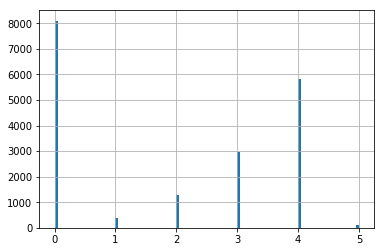

In [37]:
pd.Series(lab).hist(bins = 100)